In [2]:
%matplotlib inline


=================================
Decoding sensor space data (MVPA)
=================================

Decoding, a.k.a MVPA or supervised machine learning applied to MEG
data in sensor space. Here the classifier is applied to every time
point.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

data_path = sample.data_path()

plt.close('all')

# sphinx_gallery_thumbnail_number = 4

Successfully extracted to: ['/home/karim/mne_data/MNE-sample-data']


Set parameters



In [3]:
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = dict(audio_left=1, visual_left=3)

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True)

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the examlpe to run faster.
raw.filter(None, 20., fir_design='firwin')
events = mne.find_events(raw, 'STI 014')

# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more
picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=True, eog=True,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')

Opening raw data file /home/karim/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Setting up low-pass filter at 20 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 396 samples (0.659 sec) selected
320 events found
Events id: [ 1  2  3  4  5 32]
145 matching events found
3 projection items activated
Loading data for 145 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EO

<Epochs  |  n_events : 123 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0.0), ~11.5 MB, data loaded,
 'audio_left': 56, 'visual_left': 67>

Temporal decoding
-----------------

We'll use a Logistic Regression for a binary classification as machine
learning model.



(123, 203, 43) (123,) [3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 3 1 3 1 3 1 3 1 1 3
 1 3 1 3 3 1 3 1 3 1 3 3 1 3 1 3 1 3 1 3 1 1 3 3 1 3 1 3 1 3 3 1 3 1 3 1 3
 1 3 3 3 1 3 3 3 3 1 3 1 3 1 1 3 1 3 1 3 1 3 1 3 3 1 3 3 1 3 3 1 3 1 3 3 3
 1 3 1 3 1 3 1 3 1 1 3 1]


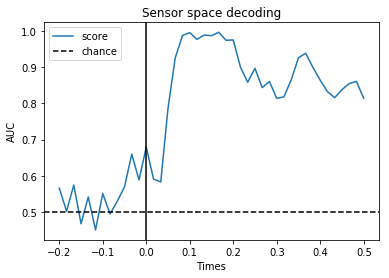

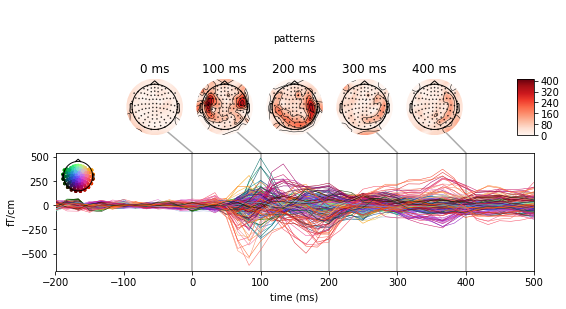

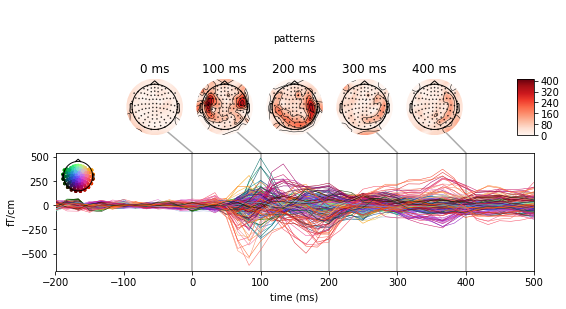

In [10]:
# We will train the classifier on all left visual vs auditory trials on MEG

X = epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right
print(X.shape,y.shape,y)

clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns')

Temporal Generalization
-----------------------

This runs the analysis used in [1]_ and further detailed in [2]_

The idea is to fit the models on each time instant and see how it
generalizes to any other time point.



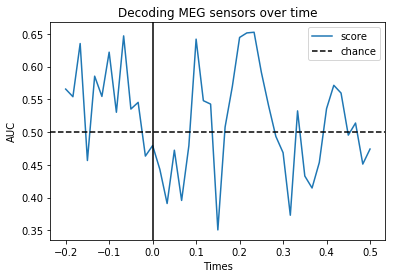

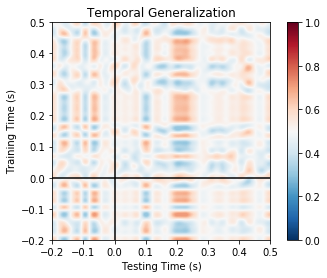

In [11]:
# define the Temporal Generalization object
X = X[:,1,:]
X = X[:,np.newaxis,:]
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc')
scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')
plt.show()

# Plot the full matrix
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal Generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)
plt.show()

In [13]:
y.shape

(123,)